In [ ]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, auc, roc_auc_score, log_loss, mean_squared_error
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# from rit.tree import DecisionTreeClassifier as MyDecisionTreeClassifier
# from rit.tree import DecisionTreeRegressor as MyDecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from rit.ensemble import RandomForestClassifier as MyRandomForestClassifier
# from rit.ensemble import RandomForestRegressor as MyRandomForestRegressor

from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_classification, make_regression

from scipy.stats import f_oneway

# Выбор оптимального $\alpha$

In [ ]:
def find_optimal_alpha_regression(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  alpha_values = np.linspace(0, 1, 21)  # От 0 до 1 с шагом 0.05

  base_model = RandomForestRegressor(random_state=0)
  base_model.fit(X_train, y_train)
  y_base_pred = base_model.predict(X_test)

  predictions = [y_base_pred]

  for alpha in alpha_values:
      rit_model = MyRandomForestRegressor(random_state=0, max_depth=int(10 * alpha))
      rit_model.fit(X_train, y_train)
      y_rit_pred = rit_model.predict(X_test)
      predictions.append(y_rit_pred)

  f_statistic, p_value = f_oneway(*predictions)

  threshold = 0.05
  valid_alphas = [alpha for alpha, p in zip([0] + list(alpha_values), [p_value] * len(predictions)) if p >= threshold]

  if valid_alphas:
      max_valid_alpha = max(valid_alphas)
      print("Максимальное значение alpha, при котором гипотеза не отвергается:", max_valid_alpha)
      return max_valid_alpha
  else:
      print("Для всех значений alpha гипотеза отвергается.")
  return 0


In [ ]:
def find_optimal_alpha_classification(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  alpha_values = np.linspace(0, 1, 21)  # От 0 до 1 с шагом 0.05

  base_model = RandomForestRegressor(random_state=0)
  base_model.fit(X_train, y_train)
  y_base_pred = base_model.predict(X_test)

  predictions = [y_base_pred]

  for alpha in alpha_values:
      rit_model = MyRandomForestClassifier(random_state=42, max_depth=int(10 * alpha))
      rit_model.fit(X_train, y_train)
      y_modified_pred = rit_model.predict(X_test)

      predictions.append(y_modified_pred)

  f_statistic, p_value = f_oneway(*predictions)

  threshold = 0.05
  valid_alphas = [alpha for alpha, p in zip([0] + list(alpha_values), [p_value] * len(predictions)) if p >= threshold]

  if valid_alphas:
      max_valid_alpha = max(valid_alphas)
      print("Максимальное значение alpha, при котором гипотеза не отвергается:", max_valid_alpha)
      return max_valid_alpha
  else:
      print("Для всех значений alpha гипотеза отвергается.")
  return 0

# Генерация выборок

## Функции визуализации

In [ ]:
np.random.seed(0)

In [ ]:
def Visualise_classification_2D(X, y):
  cols = ['blue', 'red', 'green', 'yellow']
  plt.figure(figsize=(9,4))
  plt.xlim((np.min(X) - 0.5, np.max(X) + 0.5)),
  plt.ylim((np.min(X) - 0.5, np.max(X) + 0.5))

  for k in np.unique(y):
      plt.plot(X[y==k,0], X[y==k,1], 'o',
                label='класс {}'.format(k), color=cols[k])

  plt.legend(loc='best')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

In [ ]:
def Visualise_regression_2D(X, y):
  plt.figure(figsize=[9, 4])
  plt.xlim((np.min(X) - 0.5, np.max(X) + 0.5)),
  plt.ylim((np.min(X) - 0.5, np.max(X) + 0.5))

  sc = plt.scatter(X[:, 0], X[:, 1], c=y, s=5)

  plt.colorbar(sc)

  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

## Классификация (2 признака)

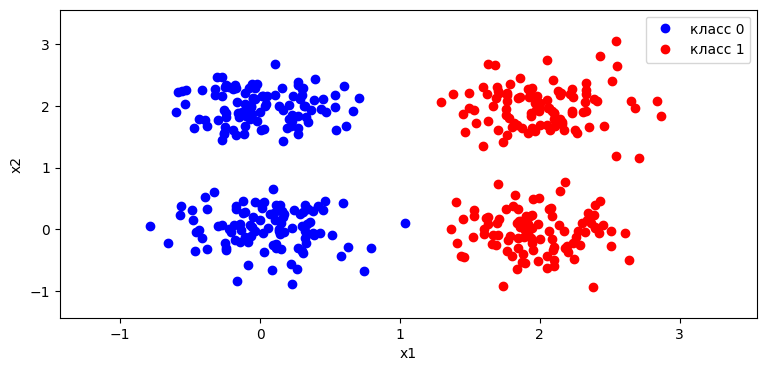

In [ ]:
def data_classification_2D_1():
  n = 2
  l = 10 ** n
  X1 = np.array([[0,0]]) + 0.3*np.random.randn(l, n)
  X2 = np.array([[0,2]]) + 0.3*np.random.randn(l, n)
  X3 = np.array([[2,0]]) + 0.3*np.random.randn(l, n)
  X4 = np.array([[2,2]]) + 0.3*np.random.randn(l, n)

  X = np.vstack([X1, X2, X3, X4])
  y = np.hstack([[0]*l, [0]*l, [1]*l, [1]*l])

  return X, y

X, y = data_classification_2D_1()
Visualise_classification_2D(X, y)

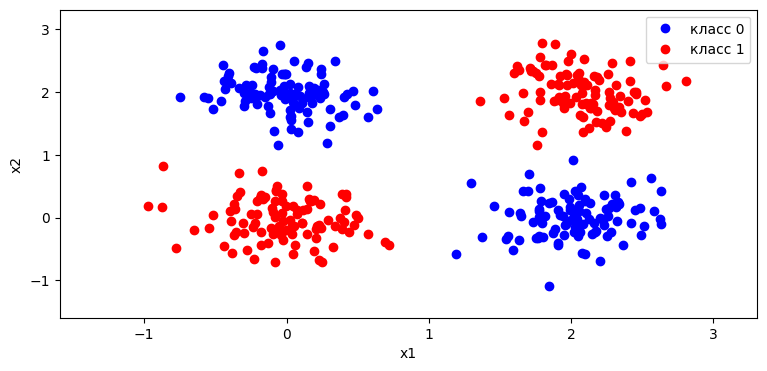

In [ ]:
def data_classification_2D_2():
  n = 2
  l = 10 ** n
  X1 = np.array([[0,0]]) + 0.3*np.random.randn(l, n)
  X2 = np.array([[0,2]]) + 0.3*np.random.randn(l, n)
  X3 = np.array([[2,0]]) + 0.3*np.random.randn(l, n)
  X4 = np.array([[2,2]]) + 0.3*np.random.randn(l, n)

  X = np.vstack([X1, X2, X3, X4])
  y = np.hstack([[1]*l, [0]*l, [0]*l, [1]*l])

  return X, y

X, y = data_classification_2D_2()
Visualise_classification_2D(X, y)

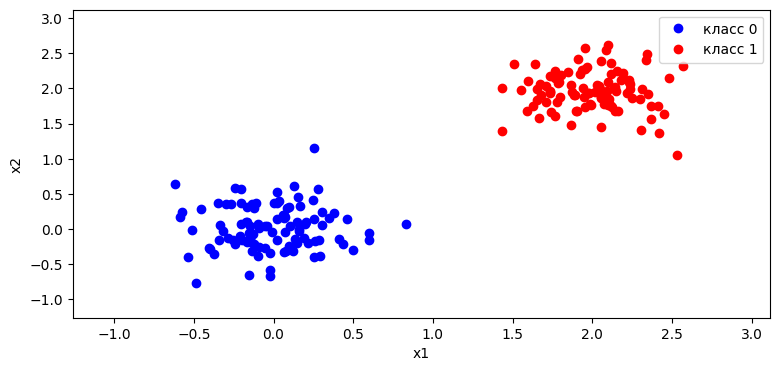

In [ ]:
def data_classification_2D_3():
  n = 2
  l = 10 ** n
  X1 = np.array([[0,0]]) + 0.3*np.random.randn(l, n)
  X2 = np.array([[2,2]]) + 0.3*np.random.randn(l, n)

  X = np.vstack([X1, X2])
  y = np.hstack([[0]*l, [1]*l])

  return X, y

X, y = data_classification_2D_3()
Visualise_classification_2D(X, y)

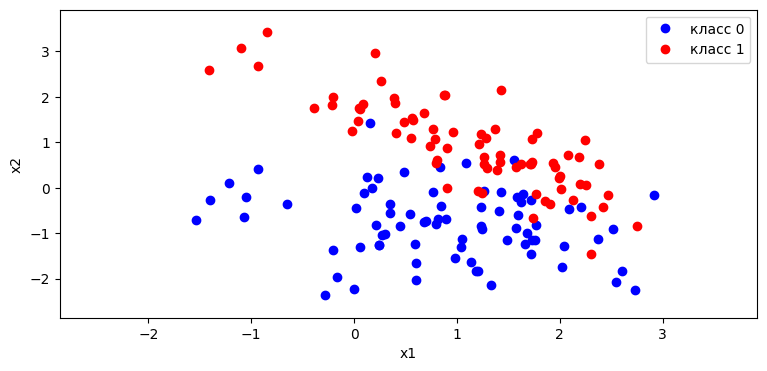

In [ ]:
def data_classification_2D_4():
  X, y = make_classification(n_samples=150, n_features=2,
                            n_informative=2, n_classes=2,
                            n_redundant=0,
                            n_clusters_per_class=1,
                            random_state=0)
  return X, y

X, y = data_classification_2D_4()
Visualise_classification_2D(X, y)

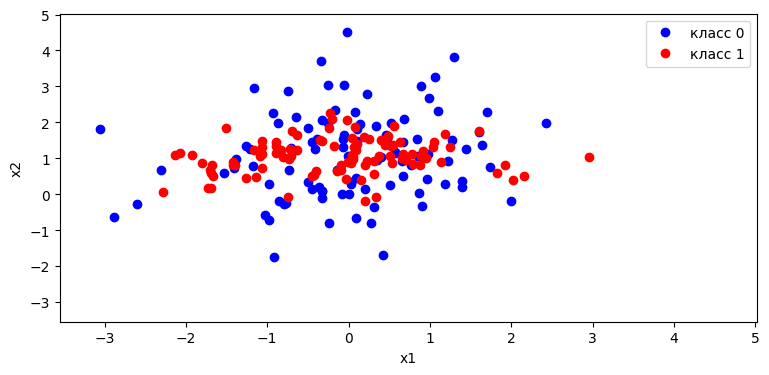

In [ ]:
def data_classification_2D_5():
  X, y = make_classification(n_samples=200, n_features=3,
                            n_informative=2, n_classes=2,
                            n_redundant=0,
                            n_clusters_per_class=1,
                            random_state=3)
  return X, y

X, y = data_classification_2D_5()
Visualise_classification_2D(X, y)

## Регрессия (2 признака)

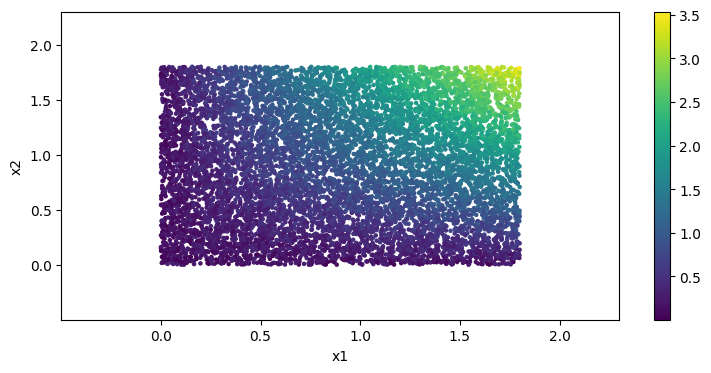

In [ ]:
def data_regression_2D_1():
  n = 2
  N = 100**n

  X1 = np.random.random(N)*1.8
  X2 = np.random.random(N)*1.8

  y = X1 * X2 + np.random.random(N)/3
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

X, y = data_regression_2D_1()
Visualise_regression_2D(X, y)

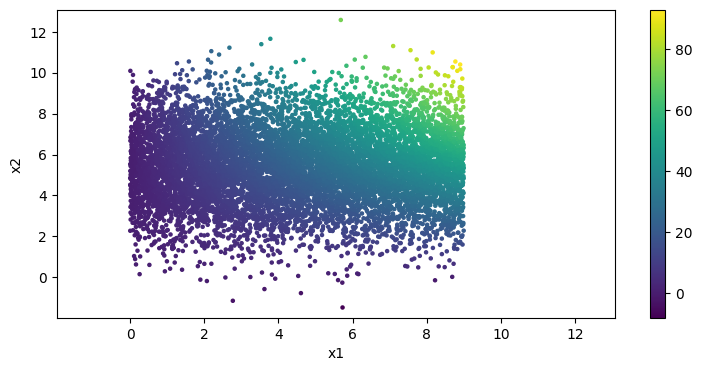

In [ ]:
def data_regression_2D_2():
  n = 2
  N = 100**n

  X1 = np.random.uniform(0, 5, N)*1.8
  X2 = np.random.normal(3, 1, N)*1.8

  y = X1 * X2 + np.random.random(N)/3
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

X, y = data_regression_2D_2()
Visualise_regression_2D(X, y)

# Методы оценки взаимодействия признаков

## Структура отдельного дерева

In [ ]:
def draw_tree(tree, feature_names):
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node with value={value}.".format(
                    space=node_depth[i] * "\t", node=i, value=np.around(values[i], 3)
                )
            )
        else:
            print(
                "{space}node={node} is a split node with value={value}: "
                "go to node {left} if {feature} <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=feature_names[feature[i]],
                    threshold=threshold[i],
                    right=children_right[i],
                    value=np.around(values[i], 3),
                )
            )

## Матрицы

1. В матрицу A записываются очки за то, что признак идёт после другого признака. Если j-й признак является ребёнком i-ого, то $a_{ij} += 1$.

In [ ]:
def dependency_matrix_tree_ver_1(tree, n_features):
    matrix = np.zeros((n_features,  n_features))

    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
            matrix[feature[node_id]][feature[children_left[node_id]]] += 1
            matrix[feature[node_id]][feature[children_right[node_id]]] += 1
        else:
            is_leaves[node_id] = True
    return matrix / (n_nodes - 1)

2. Теперь учитывается глубина, на которой произошла смена признака. Эвристика: чем раньше произошла смена, тем более скоррелированы признаки.

In [ ]:
def dependency_matrix_tree_ver_2(tree, n_features, func = lambda x: 1 / 2 ** x):

    matrix = np.zeros((n_features,  n_features))

    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
            matrix[feature[node_id]][feature[children_left[node_id]]] += func(depth)
            matrix[feature[node_id]][feature[children_right[node_id]]] += func(depth)
        else:
            is_leaves[node_id] = True
    return matrix / (n_nodes - 1)

3. Теперь будем учитывать коэффициент $\alpha$. Эвристика: чем больше $α$, тем сложнее новому признаку пробиться, следовательно корреляция увеличивается.

In [ ]:
def dependency_matrix_tree_ver_3(tree, n_features, alpha,  func = lambda x: 1 / 2 ** x, func2 = lambda a: 1 + a):
    matrix = np.zeros((n_features,  n_features))

    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
            matrix[feature[node_id]][feature[children_left[node_id]]] += func(depth) * func2(alpha)
            matrix[feature[node_id]][feature[children_right[node_id]]] += func(depth) * func2(alpha)
        else:
            is_leaves[node_id] = True
    return matrix / (n_nodes - 1)

Функция, применяющая выбранную модель матрицы

In [ ]:
def dependency_matrix_forest(model, n_features, alpha):
  matrix = np.zeros((n_features,  n_features))

  for tree in model.estimators_:
    matrix += dependency_matrix_tree_ver_2(tree, n_features)

  N = model.n_estimators
  matrix = matrix / N

  return matrix

# Проверка модели на сгенерированных данных

In [ ]:
def Visualise_FI(model):
  plt.figure()
  pd.Series(model.feature_importances_).sort_values(ascending=True).plot(kind='barh')
  xtl = plt.gca().get_xticklabels()
  plt.gca().set_xticklabels(xtl, fontsize=15)
  plt.gca().set_title('RF', fontsize=15)
  plt.show()

In [ ]:
def fit_classification(X, y, score_func = accuracy_score):
  alpha = find_optimal_alpha_classification(X, y)
  rf = MyRandomForestClassifier(max_features='sqrt',
                                random_state=0,
                                max_leaf_nodes=2**3,
                                bootstrap=True,
                                oob_score=score_func,
                                n_jobs=1,
                                rit_alpha=alpha,
                                subforest_importance=True,
                                normalize_importance=False)
  rf.fit(X, y)
  Visualise_FI(model)
  print(dependency_matrix_forest(rf, len(X[0]), alpha))


In [ ]:
def fit_regression(X, y, score_func = mean_squared_error):
  alpha = find_optimal_alpha_regression(X, y)
  rf = MyRandomForestRegressor(random_state=0,
                               max_leaf_nodes=2**2,
                               bootstrap=True,
                               oob_score=score_func,
                               n_jobs=1,
                               rit_alpha=alpha,
                               subforest_importance=True,
                               normalize_importance=False,
                               importance_avrg='median')
  rf.fit(X, y)
  Visualise_FI(model)
  print(dependency_matrix_forest(rf, len(X[0]), alpha))

RandomForestRegressor(importance_avrg='median', max_leaf_nodes=4, n_jobs=1,
                      normalize_importance=False,
                      oob_score=<function neg_mean_squared_error at 0x731394b2c790>,
                      random_state=0, rit_alpha=0.1, subforest_importance=True)

## Классификация

In [ ]:
X, y = data_classification_2D_1()
fit_classification(X, y)

In [ ]:
X, y = data_classification_2D_2()
fit_classification(X, y)

In [ ]:
X, y = data_classification_2D_3()
fit_classification(X, y)

In [ ]:
X, y = data_classification_2D_4()
fit_classification(X, y)

In [ ]:
X, y = data_classification_2D_5()
fit_classification(X, y)

## Регрессия

In [ ]:
X, y = data_regression_2D_1()
fit_regression(X, y)

In [ ]:
X, y = data_regression_2D_2()
fit_regression(X, y)

# TEST

In [ ]:
# def neg_mean_squared_error(
#     y_true,
#     y_pred,
#     *,
#     sample_weight=None,
#     multioutput="uniform_average",
#     squared="deprecated",
# ):
#     return -mean_squared_error(y_true, y_pred,
#                                sample_weight=sample_weight,
#                                multioutput=multioutput,
#                                squared=squared)

In [ ]:
model = RandomForestClassifier(n_estimators = 1000, random_state=0,
                               bootstrap=True,
                               oob_score=accuracy_score,
                               max_depth= 10)
X, y = data_classification_2D_5()

_ = model.fit(X, y)

In [ ]:
#  plt.figure(figsize=(19, 4))
#  plot_decision_regions(X, y, model)
#  plt.show()

In [ ]:
print(dependency_matrix_forest(model, 3, 0.1))
print(dependency_matrix_tree_ver_2(model.estimators_[0], 3))
print(dependency_matrix_tree_ver_1(model.estimators_[0], 3))

[[0.01872401 0.04142339 0.02440081]
 [0.01763106 0.05595847 0.02504033]
 [0.01608366 0.10072809 0.01459508]]
[[0.05  0.1   0.   ]
 [0.    0.075 0.   ]
 [0.1   0.1   0.   ]]
[[0.1 0.3 0. ]
 [0.  0.4 0. ]
 [0.1 0.1 0. ]]
